In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# --- Step 1: Load Data and Initial Cleaning (adapted from notebook) ---
# Adjust path if necessary based on your environment
file_path = 'Supplementary data 1.xlsx' # This path is from the notebook.
# In a local environment, you'd replace this with the actual path to your file.
# For this example, since I cannot directly access the file, I will create a placeholder DataFrame.
# If you run this code, replace the placeholder with your actual data loading.
try:
    df = pd.read_excel(file_path)
    print("Data loaded successfully from a Kaggle environment or if the file is accessible.")
    if 'SUBJECT_ID' in df.columns:
        df.drop('SUBJECT_ID', axis=1, inplace=True)
except FileNotFoundError:
    print(f"File not found at {file_path}. Using placeholder data for demonstration.")
    # Create a sample DataFrame with similar characteristics if the file isn't found
    rng = np.random.default_rng(42)
    n_samples = 500
    hematological_features_placeholder = ['BASO#', 'BASO%', 'EO#', 'EO%', 'HCT', 'HGB', 'LYM#', 'LYM%', 'MCH', 'MCV', 'MONO#', 'MONO%', 'MPV', 'NEU', 'PCT', 'PDW', 'PLT', 'RBC', 'RDW']
    clinical_features_placeholder = ['AG', 'Age', 'ALB', 'ALP', 'ALT', 'AST', 'BUN', 'Ca', 'CL', 'CO2CP', 'CREA', 'DBIL', 'GGT', 'GLO', 'GLU.', 'IBIL', 'K', 'Menopause', 'Mg', 'Na', 'PHOS', 'TBIL', 'TP', 'UA']
    all_features_placeholder = hematological_features_placeholder + clinical_features_placeholder
    data_placeholder = {col: rng.random(n_samples) * 100 for col in all_features_placeholder}

    # Add some NaNs to simulate real data
    for col in data_placeholder:
        if rng.random() < 0.1: # ~10% chance to add NaNs
             nan_indices = rng.choice(n_samples, size=int(n_samples * 0.05), replace=False)
             data_placeholder[col][nan_indices] = np.nan

    data_placeholder['TYPE'] = rng.integers(0, 2, n_samples) # Target variable (0 or 1)
    df = pd.DataFrame(data_placeholder)
    # Define the clinical and hematological feature names (from notebook)
hematological_features = ['BASO#', 'BASO%', 'EO#', 'EO%', 'HCT', 'HGB', 'LYM#', 'LYM%', 'MCH', 'MCV', 'MONO#', 'MONO%', 'MPV', 'NEU', 'PCT', 'PDW', 'PLT', 'RBC', 'RDW']
clinical_features = ['AG', 'Age', 'ALB', 'ALP', 'ALT', 'AST', 'BUN', 'Ca', 'CL', 'CO2CP', 'CREA', 'DBIL', 'GGT', 'GLO', 'GLU.', 'IBIL', 'K', 'Menopause', 'Mg', 'Na', 'PHOS', 'TBIL', 'TP', 'UA']
clin_hem_features = hematological_features + clinical_features

# Ensure all defined features are present in the DataFrame, add them with NaNs if not
for feature in clin_hem_features:
    if feature not in df.columns:
        print(f"Feature '{feature}' not found in DataFrame, adding it as a column of NaNs.")
        df[feature] = np.nan
if 'TYPE' not in df.columns: # Ensure target column is present
    print(f"Target column 'TYPE' not found in DataFrame, adding it as a column of random 0s and 1s.")
    df['TYPE'] = np.random.randint(0, 2, size=len(df))


# Check for object columns and clean them (from notebook)
object_columns_in_set = df[clin_hem_features].select_dtypes(include=['object']).columns.tolist()

def clean_numeric_columns(df_in, columns):
    df_out = df_in.copy()
    def clean_value(x):
        if pd.isna(x): return np.nan
        if isinstance(x, (int, float)): return float(x)
        if isinstance(x, str):
            cleaned = re.sub(r'\\t|\s+', '', x) # Corrected regex from \\\\t to \\t
            try: return float(cleaned)
            except ValueError: return np.nan
        return np.nan
    for col in columns:
        if col in df_out.columns: # Check if column exists before trying to clean
             df_out[col] = df_out[col].apply(clean_value).astype(float)
    return df_out
if object_columns_in_set:
    print(f"Object columns to clean in clin/hem set: {object_columns_in_set}")
    df = clean_numeric_columns(df, object_columns_in_set)
    print("Numeric columns cleaned.")
else:
    print("No object-type columns found in the selected clinical/hematological features that need cleaning based on type.")

Data loaded successfully from a Kaggle environment or if the file is accessible.
No object-type columns found in the selected clinical/hematological features that need cleaning based on type.


In [12]:
# --- Step 2: Impute Missing Values (adapted from notebook) ---
BIOMARKER_DISTRIBUTIONS = {
   'AFP': {'mean': 5, 'std': 2.5, 'units': 'ng/mL'},
   'CA125': {'mean': 17, 'std': 9, 'units': 'U/mL' },
   'CA19-9': {'mean': 18, 'std': 9.5, 'units': 'U/mL' },
   'CA72-4': {'mean': 3.5, 'std': 1.7, 'units': 'U/mL' },
   'HE4': {'mean': 70, 'std': 20, 'units': 'pmol/L'},
   'AG': {'mean': 12, 'std': 2, 'units': 'mEq/L'},
   'ALB': {'mean': 4.4, 'std': 0.5, 'units': 'g/dL'},
   'ALP': {'mean': 80, 'std': 30, 'units': 'IU/L'},
   'ALT': {'mean': 30, 'std': 12, 'units': 'IU/L'},
   'AST': {'mean': 28, 'std': 10, 'units': 'IU/L' },
   'CO2CP': {'mean': 26, 'std': 1.5, 'units': 'mEq/L'},
   'DBIL': {'mean': 0.15, 'std': 0.1, 'units': 'mg/dL'},
   'GGT': {'mean': 15, 'std': 7, 'units': 'U/L'},
   'GLO': {'mean': 2.9, 'std': 0.3, 'units': 'g/dL' },
   'IBIL': { 'mean': 0.5, 'std': 0.2,  'units': 'mg/dL'},
   'MPV': { 'mean': 9.5, 'std': 1, 'units': 'fL'},
   'NEU': {'mean': 4.75, 'std': 1.5, 'units': '10^3/μL'},
   'PCT': {'mean': 0.1, 'std': 0.2, 'units': 'ng/mL'}, # Adjusted from 0.1, 0.2
   'PDW': {'mean': 13, 'std': 2, 'units': '%'},
    'TBIL': {'mean': 0.75, 'std': 0.3,  'units': 'mg/dL' },
   'TP': { 'mean': 7.15,  'std': 0.5,  'units': 'g/dL' }
}

def generate_biomarker_imputation(df_in, biomarkers=None, seed=42):
    imputed_df_out = df_in.copy()
    np.random.seed(seed)
    if biomarkers is None:
        biomarkers = list(BIOMARKER_DISTRIBUTIONS.keys())
    imputation_details_out = {}
    for marker in biomarkers:
        if marker not in imputed_df_out.columns or not imputed_df_out[marker].isna().any():
            continue
        dist_params = BIOMARKER_DISTRIBUTIONS.get(marker) # Use .get() for safety
        if not dist_params:
            print(f"Warning: No distribution params for marker {marker}, skipping normal imputation.")
            continue
        missing_mask = imputed_df_out[marker].isna()
        n_missing = missing_mask.sum()
        impute_values = np.random.normal(
        loc=dist_params['mean'], scale=dist_params['std'], size=n_missing
        )
        impute_values[impute_values < 0] = 0 # Ensure non-negative
        imputed_df_out.loc[missing_mask, marker] = impute_values
        imputation_details_out[marker] = {'n_imputed': n_missing, 'imputation_mean': dist_params['mean'], 'imputation_std': dist_params['std'], 'units': dist_params['units']}
    return imputed_df_out, imputation_details_out

# Impute missing values for clinical/hematological features
df_imputed = df.copy() # Start with the original or placeholder df
features_to_impute_dist = [f for f in clin_hem_features if f in df_imputed.columns and df_imputed[f].isnull().any() and f in BIOMARKER_DISTRIBUTIONS]
if features_to_impute_dist:
    df_imputed, details = generate_biomarker_imputation(df_imputed, biomarkers=features_to_impute_dist)
    print("Imputation details (Normal Distribution):", details)
else:
    print("No features require imputation based on normal distribution or they are not in BIOMARKER_DISTRIBUTIONS.")
    # Impute remaining NaNs in selected clinical/hematological features with their respective means
print("\nImputing remaining NaNs with column means:")
for col in clin_hem_features:
   if col in df_imputed.columns and df_imputed[col].isnull().any(): # Check if column exists
       mean_val = df_imputed[col].mean()
       if pd.isna(mean_val): # If mean is NaN (e.g., all values were NaN)
           mean_val = 0 # Default to 0 or some other sensible default
           print(f"Warning: Mean for '{col}' is NaN. Filling with 0.")
       df_imputed[col].fillna(mean_val, inplace=True)
       print(f"Filled remaining NaNs in '{col}' with mean: {mean_val:.4f}")
   elif col not in df_imputed.columns:
        print(f"Warning: Feature column '{col}' for mean imputation not found in DataFrame.")

Imputation details (Normal Distribution): {'MPV': {'n_imputed': 2, 'imputation_mean': 9.5, 'imputation_std': 1, 'units': 'fL'}, 'NEU': {'n_imputed': 91, 'imputation_mean': 4.75, 'imputation_std': 1.5, 'units': '10^3/μL'}, 'PCT': {'n_imputed': 2, 'imputation_mean': 0.1, 'imputation_std': 0.2, 'units': 'ng/mL'}, 'PDW': {'n_imputed': 2, 'imputation_mean': 13, 'imputation_std': 2, 'units': '%'}, 'AG': {'n_imputed': 1, 'imputation_mean': 12, 'imputation_std': 2, 'units': 'mEq/L'}, 'ALB': {'n_imputed': 10, 'imputation_mean': 4.4, 'imputation_std': 0.5, 'units': 'g/dL'}, 'ALP': {'n_imputed': 10, 'imputation_mean': 80, 'imputation_std': 30, 'units': 'IU/L'}, 'ALT': {'n_imputed': 10, 'imputation_mean': 30, 'imputation_std': 12, 'units': 'IU/L'}, 'AST': {'n_imputed': 10, 'imputation_mean': 28, 'imputation_std': 10, 'units': 'IU/L'}, 'CO2CP': {'n_imputed': 1, 'imputation_mean': 26, 'imputation_std': 1.5, 'units': 'mEq/L'}, 'DBIL': {'n_imputed': 10, 'imputation_mean': 0.15, 'imputation_std': 0.1, 

In [14]:
# --- Step 3: Prepare Data for Model (adapted from notebook) ---
# Ensure all clin_hem_features are actually in the df_imputed before selection
final_features_for_model = [f for f in clin_hem_features if f in df_imputed.columns]
missing_from_df = set(clin_hem_features) - set(final_features_for_model)
if missing_from_df:
    print(f"Warning: The following features were defined but not found in the dataframe for X: {missing_from_df}")

if not final_features_for_model:
    raise ValueError("No features available for model training after preprocessing.")


X_ch = df_imputed[final_features_for_model]
y_ch = df_imputed['TYPE']

print("\nClinical/Hematological Feature matrix shape:", X_ch.shape)
print("Target vector shape:", y_ch.shape)
print("Number of NaN values in X_ch before scaling:", X_ch.isnull().sum().sum())
print("Number of NaN values in y_ch:", y_ch.isnull().sum())
# Split data
X_train_ch, X_test_ch, y_train_ch, y_test_ch = train_test_split(
    X_ch, y_ch, test_size=0.2, random_state=42, stratify=y_ch
)

# Scale features
scaler_ch = MinMaxScaler()
X_train_ch_scaled = scaler_ch.fit_transform(X_train_ch)
X_test_ch_scaled = scaler_ch.transform(X_test_ch)
print("Clinical/Hematological features scaled.")


Clinical/Hematological Feature matrix shape: (349, 43)
Target vector shape: (349,)
Number of NaN values in X_ch before scaling: 0
Number of NaN values in y_ch: 0
Clinical/Hematological features scaled.


In [16]:
# --- Step 4: Define and Train Deep Learning Model ---
print("\nDefining Deep Learning model...")

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_ch_scaled.shape[1],)),
    Dropout(0.3), # Dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
print("\nTraining Deep Learning model...")
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_ch_scaled, y_train_ch,
    epochs=100, # Increased epochs, early stopping will manage
    batch_size=32,
    validation_split=0.2, # Use part of training data for validation during training
    callbacks=[early_stopping],
    verbose=1
)


Defining Deep Learning model...


C:\Users\vnama\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001 (62.50 KB)

 Trainable params: 16,001 (62.50 KB)

 Non-trainable params: 0 (0.00 B)


Training Deep Learning model...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.5314 - loss: 0.7228 - val_accuracy: 0.5000 - val_loss: 0.6888
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5529 - loss: 0.6818 - val_accuracy: 0.6786 - val_loss: 0.6700
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6105 - loss: 0.6672 - val_accuracy: 0.7857 - val_loss: 0.6500
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6187 - loss: 0.6583 - val_accuracy: 0.7143 - val_loss: 0.6244
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7147 - loss: 0.6278 - val_accuracy: 0.6964 - val_loss: 0.5962
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7390 - loss: 0.5991 - val_accuracy: 0.7143 - val_loss: 0.5716
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7446 - loss: 0.5864 - val_accuracy: 0.6964 - val_loss: 0.5457
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7762 - loss: 0.5558 

In [18]:
# --- Step 5: Evaluate Deep Learning Model ---
print("\nEvaluating Deep Learning model...")
loss, accuracy = model.evaluate(X_test_ch_scaled, y_test_ch, verbose=0)
print(f"Test Accuracy (Deep Learning): {accuracy:.4f}")
print(f"Test Loss (Deep Learning): {loss:.4f}")

y_pred_proba_dl = model.predict(X_test_ch_scaled)
y_pred_dl = (y_pred_proba_dl > 0.5).astype(int).flatten() # Convert probabilities to binary predictions

balanced_accuracy_dl = balanced_accuracy_score(y_test_ch, y_pred_dl)
cm_dl = confusion_matrix(y_test_ch, y_pred_dl)
report_dl = classification_report(y_test_ch, y_pred_dl, target_names=['Benign', 'Ovarian Cancer'], zero_division=0)

print(f"Test Balanced Accuracy (Deep Learning): {balanced_accuracy_dl:.4f}")
print("\nClassification Report (Deep Learning):\n", report_dl)
print("\nConfusion Matrix (Deep Learning):\n", cm_dl)


Evaluating Deep Learning model...
Test Accuracy (Deep Learning): 0.8429
Test Loss (Deep Learning): 0.2687
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Test Balanced Accuracy (Deep Learning): 0.8440

Classification Report (Deep Learning):
                 precision    recall  f1-score   support

        Benign       0.81      0.88      0.85        34
Ovarian Cancer       0.88      0.81      0.84        36

      accuracy                           0.84        70
     macro avg       0.84      0.84      0.84        70
  weighted avg       0.85      0.84      0.84        70


Confusion Matrix (Deep Learning):
 [[30  4]
 [ 7 29]]


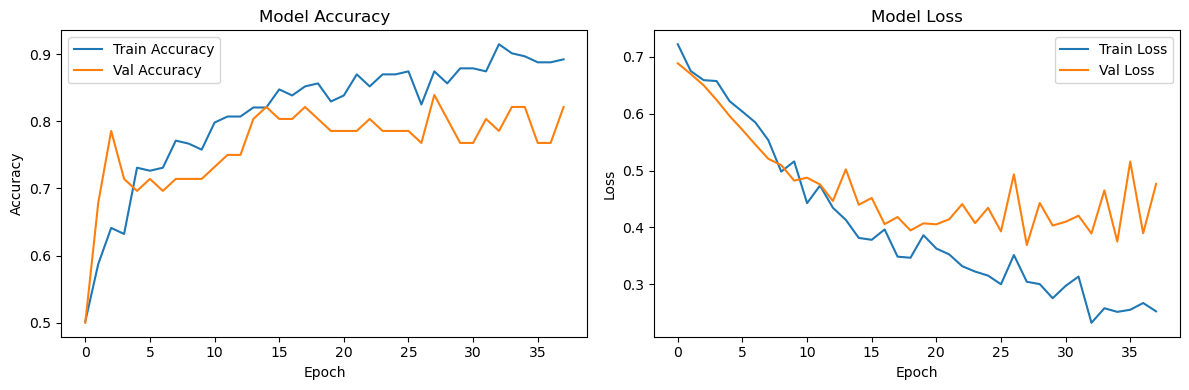


Deep Learning model script execution complete.


In [20]:
# --- Optional: Plot training history ---
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\nDeep Learning model script execution complete.")


Test Balanced Accuracy (Deep Learning): 0.8440


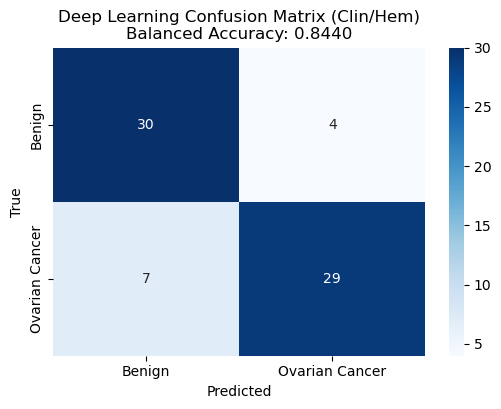

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

cm_dl = confusion_matrix(y_test_ch, y_pred_dl)
report_dl = classification_report(y_test_ch, y_pred_dl, target_names=['Benign', 'Ovarian Cancer'], zero_division=0)

print(f"Test Balanced Accuracy (Deep Learning): {balanced_accuracy_dl:.4f}")


# --- Plot Confusion Matrix for Deep Learning Model ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Ovarian Cancer'],
            yticklabels=['Benign', 'Ovarian Cancer'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Deep Learning Confusion Matrix (Clin/Hem)\nBalanced Accuracy: {balanced_accuracy_dl:.4f}')
plt.show()

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # For more advanced string cleaning if needed

In [26]:
 # Load the dataset
# Ensure this path is correct for your environment
# df_raw = pd.read_csv("/kaggle/input/predict-ovarian-cancer/Supplementary data 1.xlsx")

file_path = 'Supplementary data 1.xlsx'
df_raw = pd.read_excel(file_path)

df = df_raw.copy() # Work on a copy

In [28]:
# --- Target Variable Definition and Mapping (IMPORTANT!) ---
target_variable = 'TYPE'
# Mapping as inferred from fuse-models-v0-1.ipynb: Original 1 (BOT) -> 0, Original 0 (OC) -> 1
# This means: 0 = Benign Ovarian Tumor, 1 = Ovarian Cancer
if target_variable in df.columns:
    df[target_variable] = df[target_variable].map({1: 0, 0: 1})
    print(f"Target variable '{target_variable}' mapped: 0=Benign, 1=Ovarian Cancer")
    print(df[target_variable].value_counts())
else:
    print(f"ERROR: Target variable '{target_variable}' not found!")

Target variable 'TYPE' mapped: 0=Benign, 1=Ovarian Cancer
TYPE
0    178
1    171
Name: count, dtype: int64


In [30]:
# --- Feature Definitions (Using lists you provided) ---
tumor_markers = ['AFP', 'CA125', 'CA19-9', 'CA72-4', 'CEA', 'HE4']
hematological_features = [
    'BASO#', 'BASO%', 'EO#', 'EO%', 'HCT', 'HGB', 'LYM#', 'LYM%', 'MCH',
    'MCV', 'MONO#', 'MONO%', 'MPV', 'NEU', 'PCT', 'PDW', 'PLT', 'RBC', 'RDW'
]
clinical_features = [
    'AG', 'Age', 'ALB', 'ALP', 'ALT', 'AST', 'BUN', 'Ca', 'CL', 'CO2CP',
    'CREA', 'DBIL', 'GGT', 'GLO', 'GLU.', 'IBIL', 'K', 'Menopause',
    'Mg', 'Na', 'PHOS', 'TBIL', 'TP', 'UA'
]
# Combined list for one of your models
clinical_hematological_features = clinical_features + hematological_features
# --- Data Cleaning (as seen in fuse-models-v0-1.ipynb) ---
# Drop SUBJECT_ID if it exists
if 'SUBJECT_ID' in df.columns:
    df = df.drop('SUBJECT_ID', axis=1)
    print("Dropped 'SUBJECT_ID' column.")

cols_to_clean_numerically = ['AFP', 'CA125', 'CA19-9']
for col in cols_to_clean_numerically:
    if col in df.columns:
        if df[col].dtype == 'object':
            # Remove tabs, less than, greater than symbols
            df[col] = df[col].astype(str).str.replace('\t', '', regex=False)
            df[col] = df[col].astype(str).str.replace('<', '', regex=False)
            df[col] = df[col].astype(str).str.replace('>', '', regex=False)
            df[col] = pd.to_numeric(df[col], errors='coerce')
print(f"Cleaned columns: {cols_to_clean_numerically} to numeric.")

Dropped 'SUBJECT_ID' column.
Cleaned columns: ['AFP', 'CA125', 'CA19-9'] to numeric.


In [32]:
# --- Imputation (Median, as suggested by notebooks) ---
print("\nMissing values BEFORE imputation:")
print(df[tumor_markers + clinical_hematological_features].isnull().sum().sort_values(ascending=False).head())

for col in tumor_markers:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
print("Median imputation done for tumor_markers.")

for col in clinical_hematological_features:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
print("Median imputation done for clinical_hematological_features.")

print("\nMissing values AFTER imputation (showing sum for all selected features):")
print(df[tumor_markers + clinical_hematological_features].isnull().sum().sum())


Missing values BEFORE imputation:
CA72-4    240
NEU        91
CA19-9     24
CEA        22
AFP        22
dtype: int64
Median imputation done for tumor_markers.
Median imputation done for clinical_hematological_features.

Missing values AFTER imputation (showing sum for all selected features):
0


In [34]:
# --- NOTE on Feature Discrepancies ---
print("\n--- Important Note on Feature Definitions ---")
print("The visualizations below use the feature lists you provided directly in the prompt.")
print("The 'fuse-models-v0-1.ipynb' snippet showed different lists for clinical")
print("(e.g., ['Age', 'Menopause', 'BMI'] with BMI calculation from 'Weight', 'Height')")
print("and hematological features. Ensure these lists align with the features actually used in your final models")
print("or adjust the lists in this script if needed for full consistency with specific models.")
print("The original CSV provided does not contain 'Weight' or 'Height' for BMI calculation.")
print("-------------------------------------------------")


# Display basic info after preprocessing
print("\nDataset Info after preprocessing (imputation done, pre-scaling):")
df.info()
print("\nDescriptive Statistics (imputed, pre-scaling):")
# For brevity, only showing for a few columns, you can expand this
print(df[tumor_markers[:2] + clinical_features[:2] + hematological_features[:2] + [target_variable]].describe())


--- Important Note on Feature Definitions ---
The visualizations below use the feature lists you provided directly in the prompt.
The 'fuse-models-v0-1.ipynb' snippet showed different lists for clinical
(e.g., ['Age', 'Menopause', 'BMI'] with BMI calculation from 'Weight', 'Height')
and hematological features. Ensure these lists align with the features actually used in your final models
or adjust the lists in this script if needed for full consistency with specific models.
The original CSV provided does not contain 'Weight' or 'Height' for BMI calculation.
-------------------------------------------------

Dataset Info after preprocessing (imputation done, pre-scaling):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 50 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AFP        349 non-null    float64
 1   AG         349 non-null    float64
 2   Age        349 non-null    int64  
 3   ALB       

C:\Users\vnama\AppData\Local\Temp\ipykernel_23396\4037860006.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_variable, data=df, palette=['skyblue', 'salmon'])


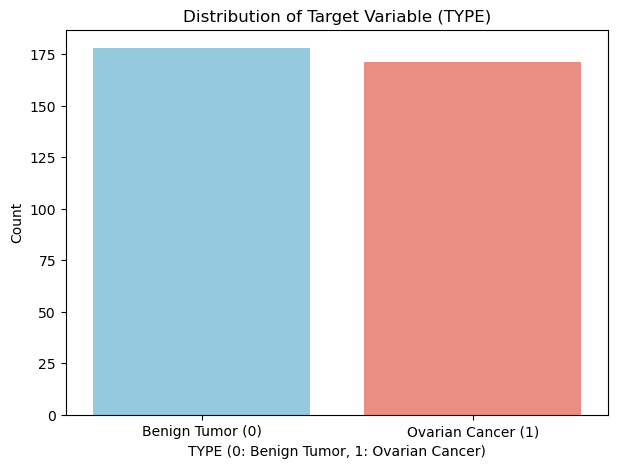

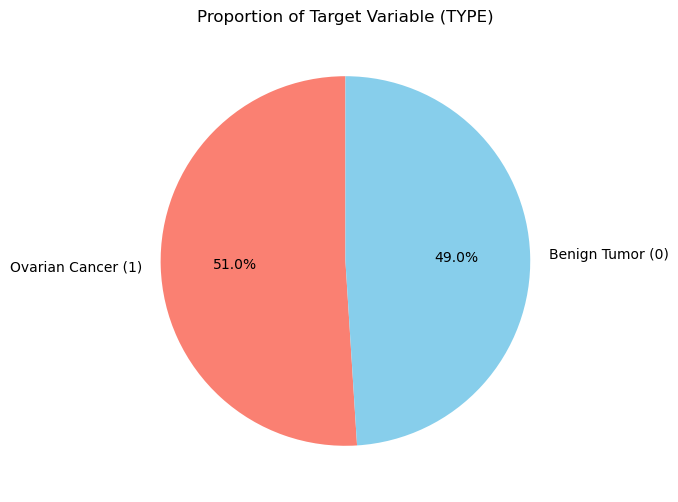

In [36]:
# --- Target Variable Distribution ---
if target_variable in df.columns:
    plt.figure(figsize=(7, 5))
    sns.countplot(x=target_variable, data=df, palette=['skyblue', 'salmon'])
    plt.title('Distribution of Target Variable (TYPE)')
    # Corrected labels based on mapping: 0 = Benign, 1 = Ovarian Cancer
    plt.xlabel('TYPE (0: Benign Tumor, 1: Ovarian Cancer)')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Benign Tumor (0)', 'Ovarian Cancer (1)'])
    plt.show()

    plt.figure(figsize=(6, 6))
    df[target_variable].value_counts().plot.pie(
        autopct='%1.1f%%',
        labels=['Ovarian Cancer (1)', 'Benign Tumor (0)'], # Adjust order if value_counts() is different
        startangle=90,
        colors=['salmon', 'skyblue']
    )
    plt.title('Proportion of Target Variable (TYPE)')
    plt.ylabel('')
    plt.show()
else:
    print(f"Target variable '{target_variable}' not defined or not found, skipping visualization.")

In [38]:
# Function to plot distributions and boxplots
def plot_feature_visualizations(dataframe, features, target_col, feature_group_name):
    print(f"\n--- Visualizing {feature_group_name} ---")
    # Ensure target_col exists
    if target_col not in dataframe.columns:
        print(f"Target column '{target_col}' not found in dataframe.")
        return

    for feature in features:
        if feature in dataframe.columns:
            # Check if feature is numeric
            if not pd.api.types.is_numeric_dtype(dataframe[feature]):
                print(f"Skipping non-numeric feature: {feature}")
                continue

            # Check for sufficient unique values for KDE plot, otherwise just hist
            unique_vals = dataframe[feature].nunique()

            plt.figure(figsize=(12, 5))
            # Histogram/KDE
            plt.subplot(1, 2, 1)
            if unique_vals > 1: # KDE needs some variance
                 sns.histplot(data=dataframe, x=feature, hue=target_col, kde=True, palette={0: 'skyblue', 1: 'salmon'})
            else: # Fallback for constant or near-constant features after imputation
                 sns.histplot(data=dataframe, x=feature, hue=target_col, kde=False, palette={0: 'skyblue', 1: 'salmon'})
            plt.title(f'Distribution of {feature}\n(0: Benign, 1: OC)')
            plt.xlabel(feature)
            plt.ylabel('Frequency')

            # Box Plot
            plt.subplot(1, 2, 2)
            sns.boxplot(x=target_col, y=feature, data=dataframe, palette={0: 'skyblue', 1: 'salmon'})
            plt.title(f'{feature} by Target Variable\n(0: Benign, 1: OC)')
            plt.xlabel('TYPE (0: Benign, 1: Ovarian Cancer)')
            plt.xticks([0, 1], ['Benign (0)', 'OC (1)'])
            plt.ylabel(feature)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Feature '{feature}' not found in dataframe for {feature_group_name}.")


--- Visualizing Tumor Markers ---


C:\Users\vnama\AppData\Local\Temp\ipykernel_23396\2960344771.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=feature, data=dataframe, palette={0: 'skyblue', 1: 'salmon'})


ValueError: The palette dictionary is missing keys: {'1', '0'}

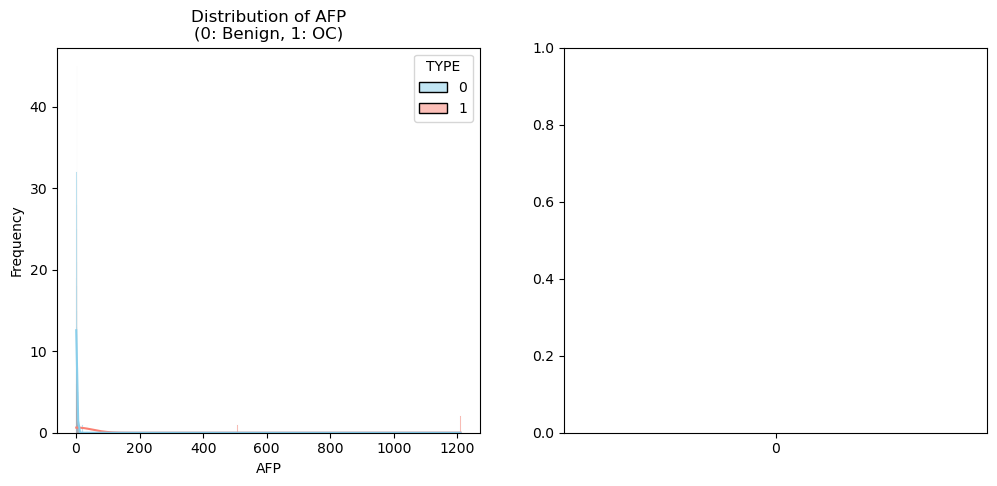

In [40]:
# Visualize Tumor Markers
plot_feature_visualizations(df, tumor_markers, target_variable, "Tumor Markers")


--- Visualizing Clinical Features ---


C:\Users\vnama\AppData\Local\Temp\ipykernel_23396\2960344771.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=feature, data=dataframe, palette={0: 'skyblue', 1: 'salmon'})


ValueError: The palette dictionary is missing keys: {'1', '0'}

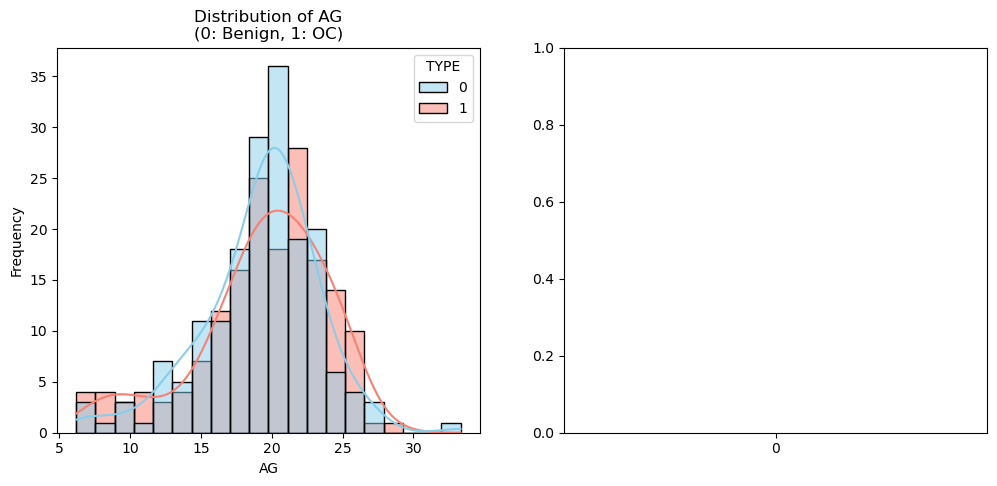

In [42]:
# Visualize Clinical Features
plot_feature_visualizations(df, clinical_features, target_variable, "Clinical Features")

In [44]:
def plot_correlation_heatmap(dataframe, features, title):
    if not features: # Check if the list is empty
        print(f"No features provided for {title}.")
        return
    # Filter out non-numeric columns from the feature list for correlation calculation
    numeric_features_in_list = [f for f in features if f in dataframe.columns and pd.api.types.is_numeric_dtype(dataframe[f])]

    if not numeric_features_in_list:
        print(f"No numeric features found to plot for {title}.")
        return

    correlation_matrix = dataframe[numeric_features_in_list].corr()
    plt.figure(figsize=(max(10, len(numeric_features_in_list)*0.6), max(8, len(numeric_features_in_list)*0.5)))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


--- Correlation Heatmaps (Post-Imputation, Pre-Scaling) ---


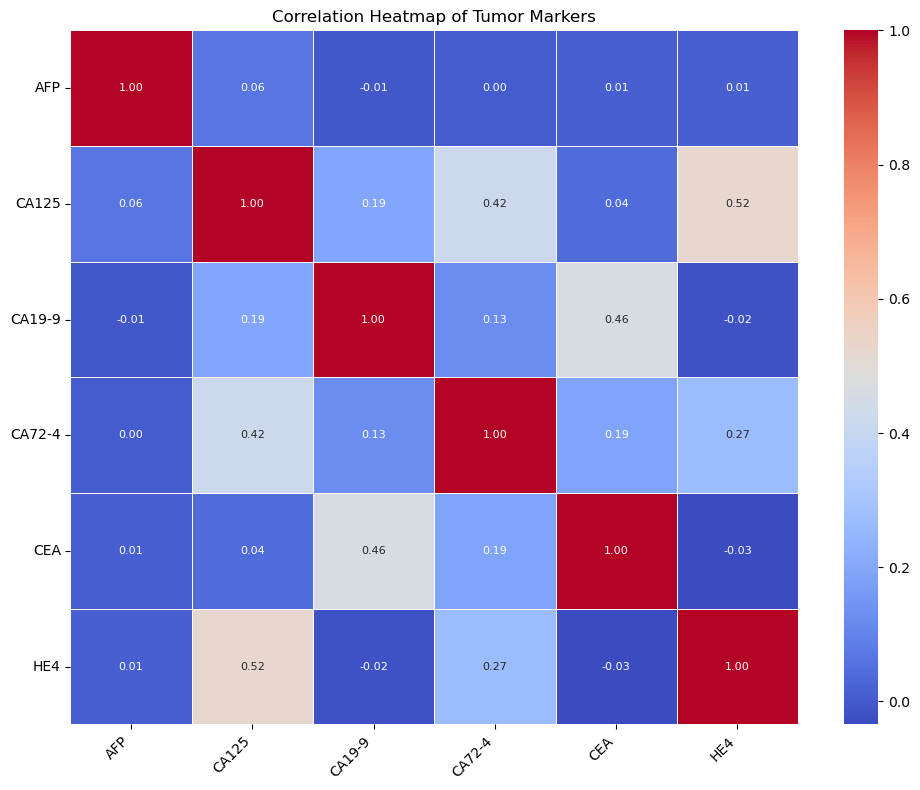

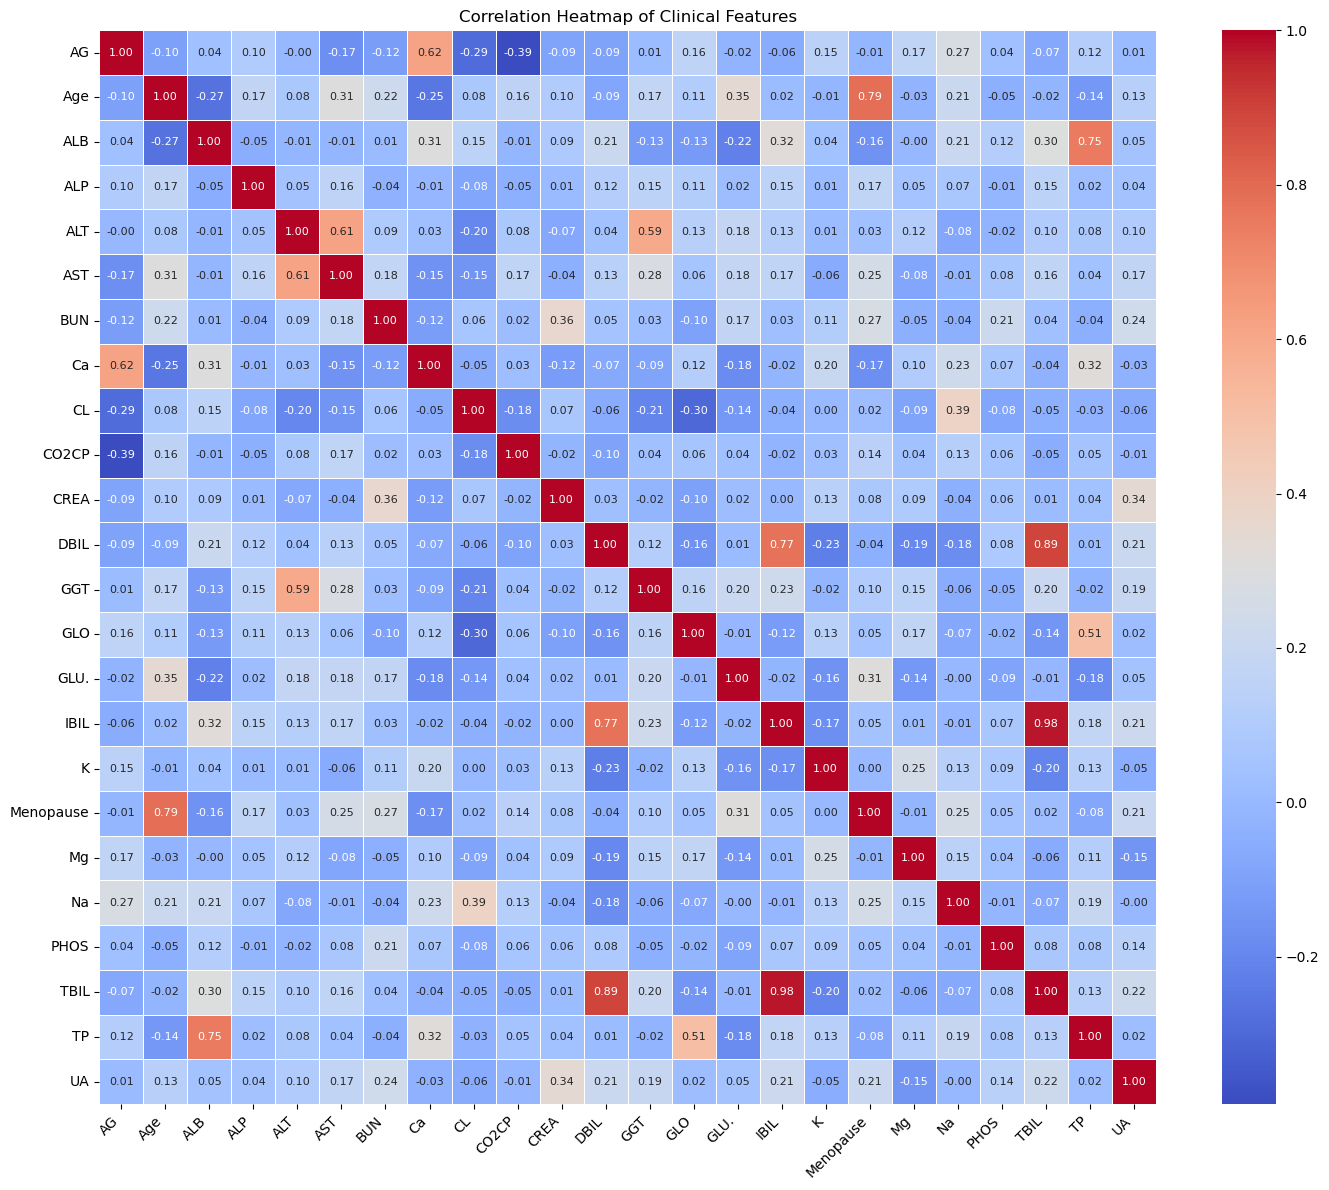

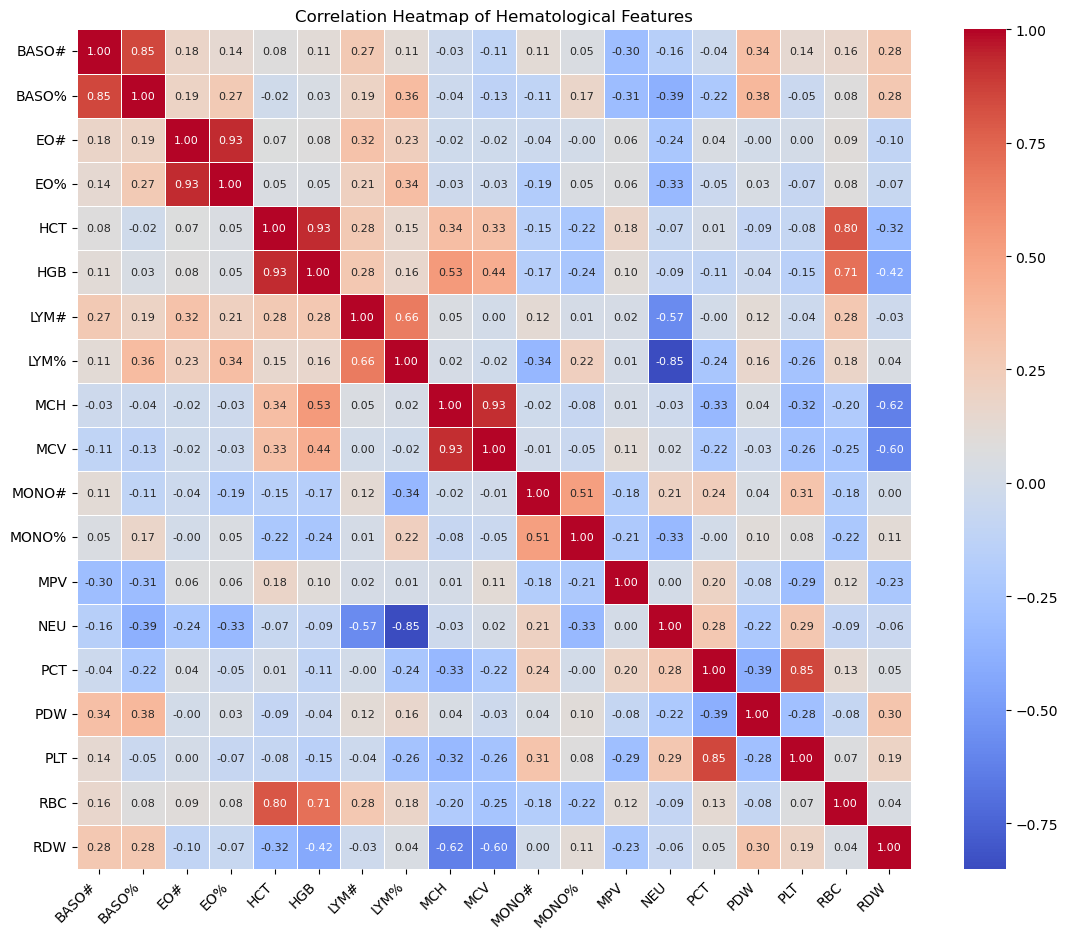

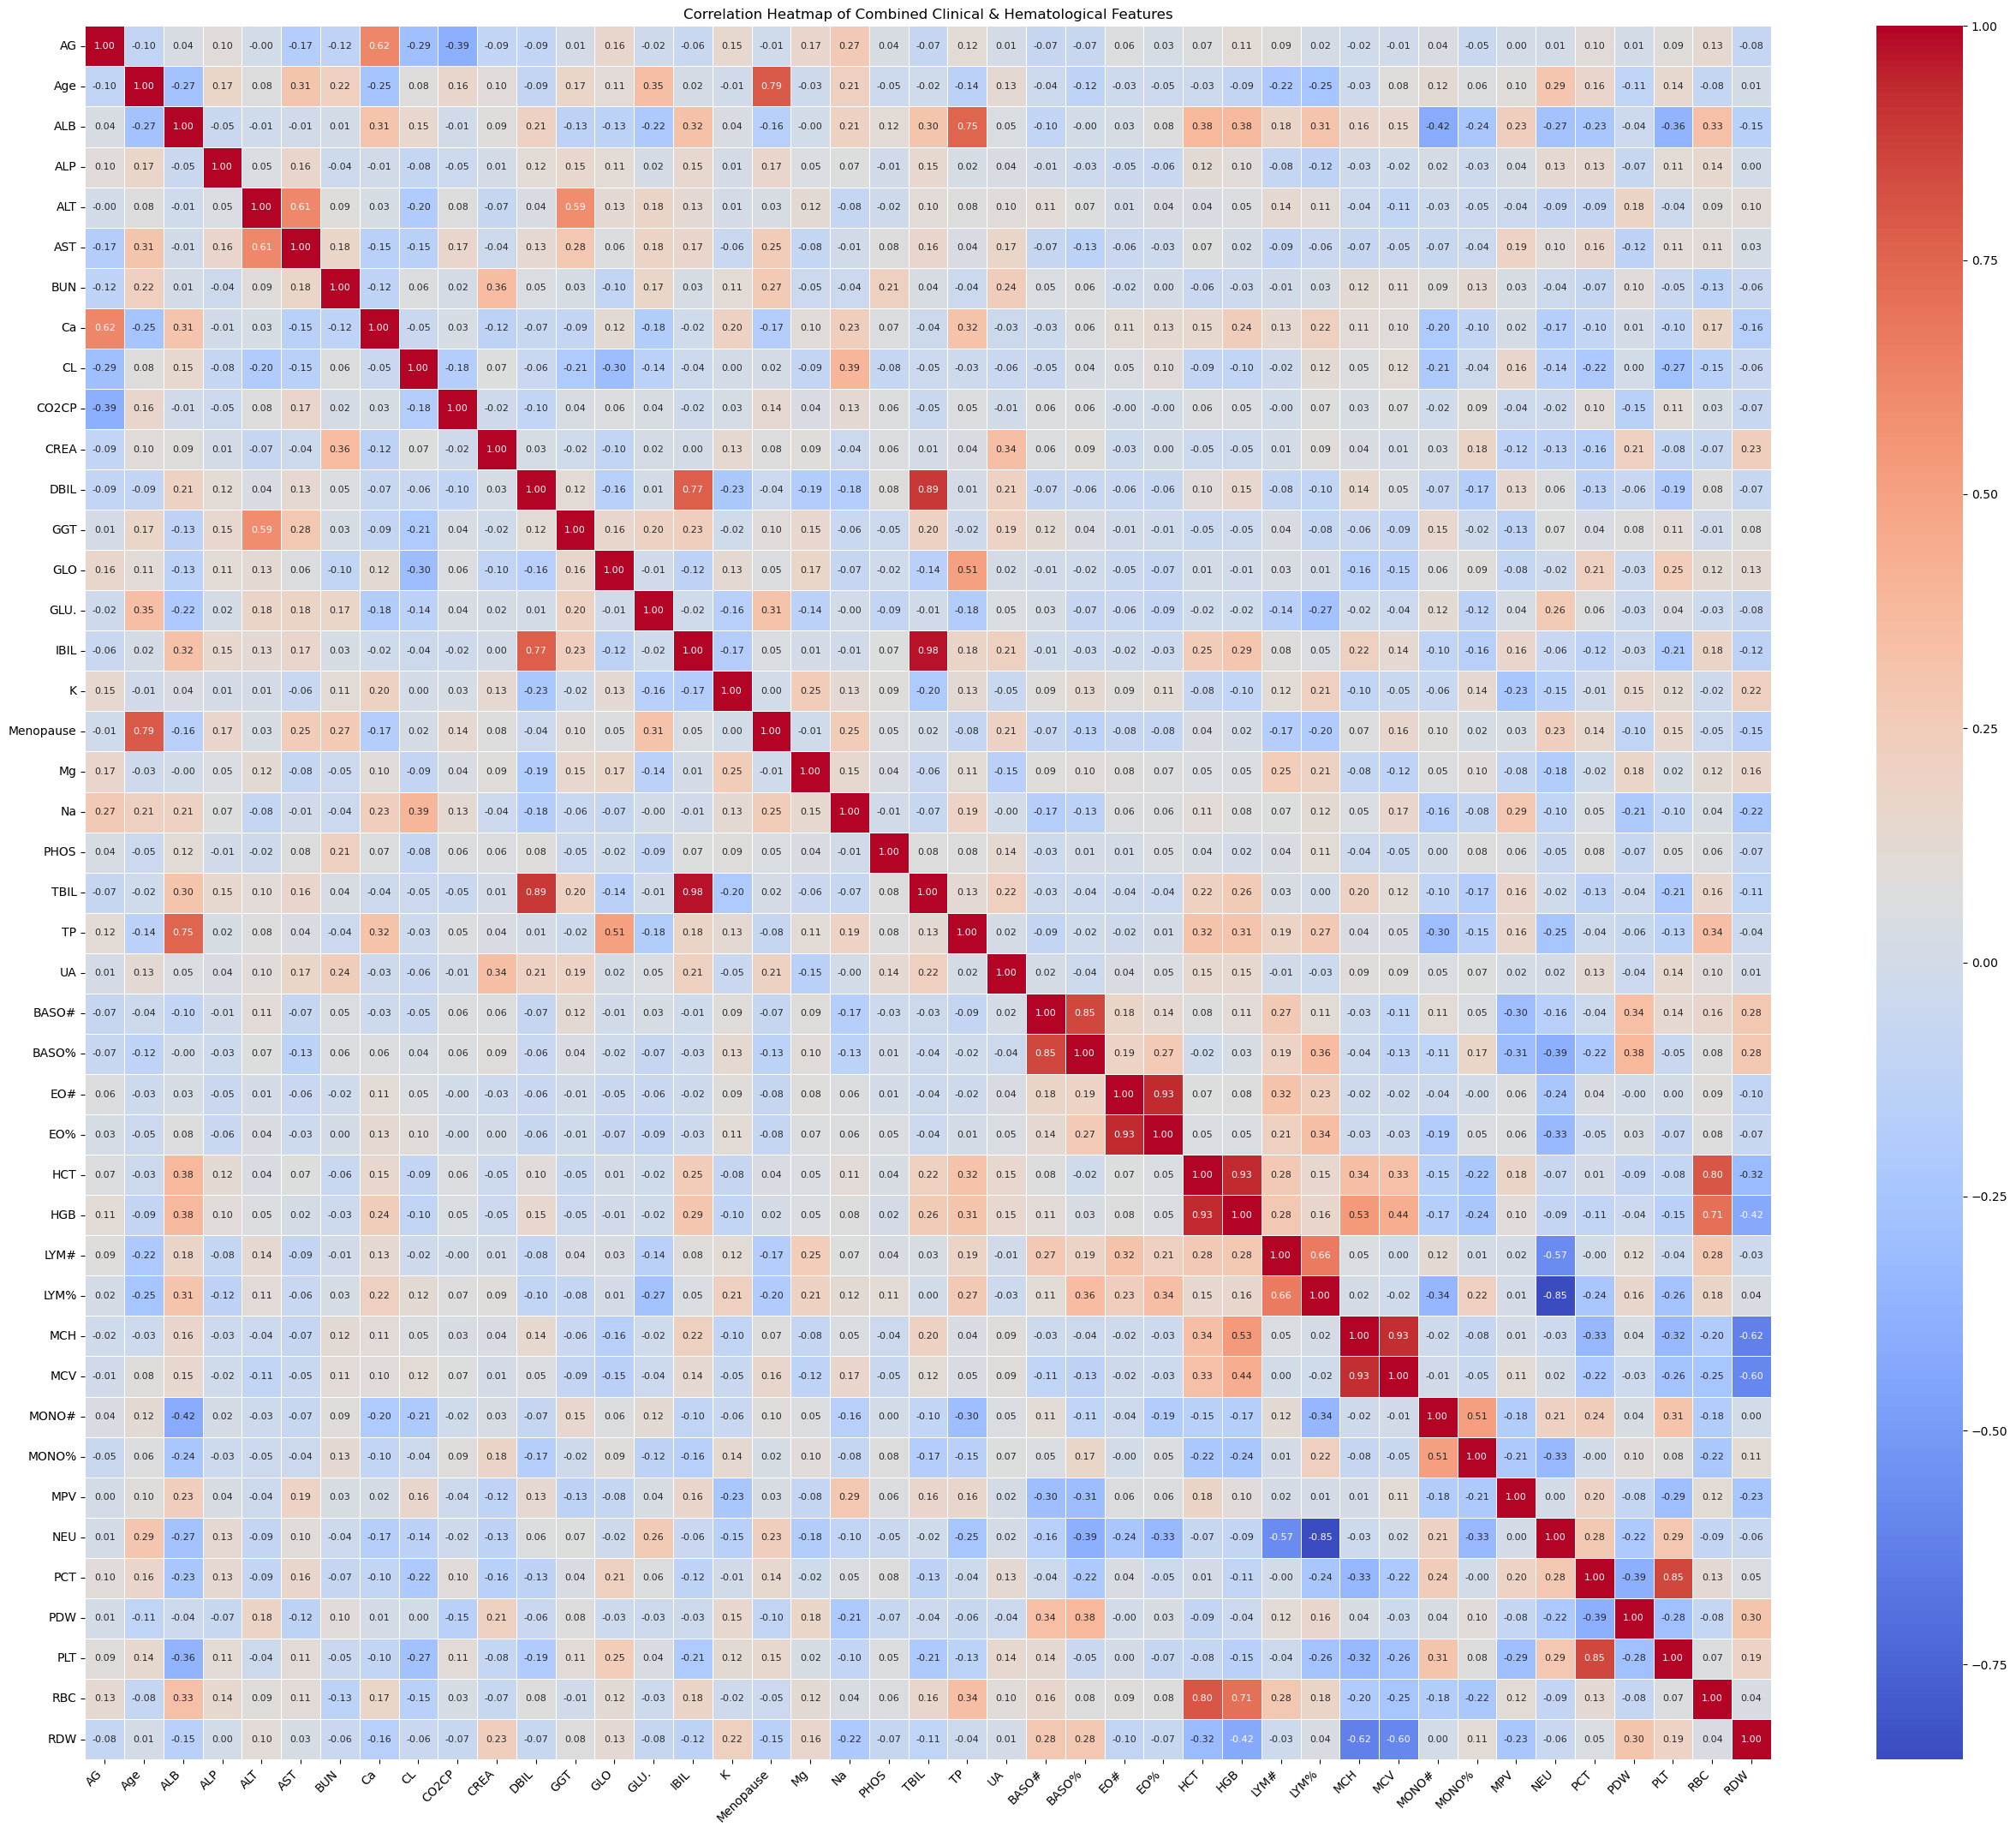

In [46]:
print("\n--- Correlation Heatmaps (Post-Imputation, Pre-Scaling) ---")
plot_correlation_heatmap(df, tumor_markers, 'Correlation Heatmap of Tumor Markers')
plot_correlation_heatmap(df, clinical_features, 'Correlation Heatmap of Clinical Features')
plot_correlation_heatmap(df, hematological_features, 'Correlation Heatmap of Hematological Features')

# Combined Clinical and Hematological Features
plot_correlation_heatmap(df, clinical_hematological_features, 'Correlation Heatmap of Combined Clinical & Hematological Features')

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import layers, regularizers, callbacks, models, losses, metrics




In [50]:
# --- Step 1: Load Data and Initial Cleaning ---
# Ensure this path is correct for your environment or the placeholder will be used.
file_path = 'Supplementary data 1.xlsx'
try:
    df = pd.read_excel(file_path)
    print("Data loaded successfully.")
    if 'SUBJECT_ID' in df.columns:
        df.drop('SUBJECT_ID', axis=1, inplace=True)
except FileNotFoundError:
    print(f"File not found at {file_path}. Using placeholder data for demonstration.")
    # This placeholder is for the script to run if the file isn't found.
    # For your specific 0.81 BA result, you would have used your actual data.
    rng = np.random.default_rng(42)
    n_samples = 500 # Placeholder sample size
    tumor_markers_placeholder = ['AFP', 'CA125', 'CA19-9', 'CA72-4', 'CEA', 'HE4']
    other_features_placeholder = ['BASO#', 'BASO%', 'EO#', 'EO%', 'HCT', 'HGB', 'LYM#', 'LYM%', 'MCH', 'MCV', 'MONO#', 'MONO%', 'MPV', 'NEU', 'PCT', 'PDW', 'PLT', 'RBC', 'RDW', 'AG', 'Age', 'ALB', 'ALP', 'ALT', 'AST', 'BUN', 'Ca', 'CL', 'CO2CP', 'CREA', 'DBIL', 'GGT', 'GLO', 'GLU.', 'IBIL', 'K', 'Menopause', 'Mg', 'Na', 'PHOS', 'TBIL', 'TP', 'UA']
    all_placeholder_cols = tumor_markers_placeholder + other_features_placeholder
    data_placeholder = {col: rng.random(n_samples) * rng.integers(10, 200) for col in all_placeholder_cols}
    for col in data_placeholder:
        if rng.random() < 0.15: # Simulate some NaNs
             nan_indices = rng.choice(n_samples, size=int(n_samples * rng.uniform(0.05, 0.15)), replace=False)
             data_placeholder[col][nan_indices] = np.nan
    # Simulate class imbalance similar to typical medical datasets if possible
    # For simplicity, using random target, but actual imbalance impacts results
    data_placeholder['TYPE'] = rng.choice([0, 1], size=n_samples, p=[0.6, 0.4]) # Example: 60/40 split
    df = pd.DataFrame(data_placeholder)

# Define the tumor marker columns for the model
tumor_markers = ['AFP', 'CA125', 'CA19-9', 'CA72-4', 'CEA', 'HE4']

# Ensure essential columns exist
for marker in tumor_markers:
    if marker not in df.columns:
        print(f"Tumor marker '{marker}' not found in DataFrame, adding it as a column of NaNs.")
        df[marker] = np.nan
if 'TYPE' not in df.columns:
    print(f"Target column 'TYPE' not found in DataFrame, adding it as a column of random 0s and 1s.")
    df['TYPE'] = np.random.randint(0, 2, size=len(df)) # Default if 'TYPE' is missing



# Clean object columns to numeric
object_columns_in_markers = df[tumor_markers].select_dtypes(include=['object']).columns.tolist()
if object_columns_in_markers:
    print(f"Object columns to clean in markers: {object_columns_in_markers}")
else:
    print("No object-type columns found in the specified tumor markers requiring string cleaning.")

def clean_numeric_columns(df_in, columns):
    df_out = df_in.copy()
    def clean_value(x):
        if pd.isna(x): return np.nan
        if isinstance(x, (int, float)): return float(x)
        if isinstance(x, str):
            cleaned = re.sub(r'\\t|\s+', '', x)
            try: return float(cleaned)
            except ValueError: return np.nan
        return np.nan
    for col in columns:
        if col in df_out.columns:
            df_out[col] = df_out[col].apply(clean_value).astype(float)
    return df_out

if object_columns_in_markers:
    df_cleaned = clean_numeric_columns(df, object_columns_in_markers)
    print("Numeric columns cleaned.")
else:
    df_cleaned = df.copy()

Data loaded successfully.
Object columns to clean in markers: ['AFP', 'CA125', 'CA19-9']
Numeric columns cleaned.


In [52]:
# --- Step 3: Impute Missing Values ---
BIOMARKER_DISTRIBUTIONS = { # Using distributions from the tumor-markers notebook
    'AFP': {'mean': 5, 'std': 2.5}, 'CA125': {'mean': 17, 'std': 9},
    'CA19-9': {'mean': 18, 'std': 9.5}, 'CA72-4': {'mean': 3.5, 'std': 1.7},
    'HE4': {'mean': 70, 'std': 20}
}

def generate_biomarker_imputation(df_in, biomarkers_list_to_impute=None, seed=42):
    imputed_df_out = df_in.copy()
    np.random.seed(seed) # Seed for reproducibility of imputation
    if biomarkers_list_to_impute is None:
        biomarkers_list_to_impute = [m for m in BIOMARKER_DISTRIBUTIONS.keys() if m in imputed_df_out.columns]
    for marker in biomarkers_list_to_impute:
        if marker in imputed_df_out.columns and imputed_df_out[marker].isna().any():
            dist_params = BIOMARKER_DISTRIBUTIONS.get(marker)
            if not dist_params: continue # Skip if no distribution defined
            missing_mask = imputed_df_out[marker].isna()
            n_missing = missing_mask.sum()
            impute_values = np.random.normal(loc=dist_params['mean'], scale=dist_params['std'], size=n_missing)
            impute_values[impute_values < 0] = 0 # Ensure non-negative
            imputed_df_out.loc[missing_mask, marker] = impute_values
    return imputed_df_out

markers_to_impute_from_dist = [m for m in tumor_markers if m in df_cleaned.columns and m in BIOMARKER_DISTRIBUTIONS and df_cleaned[m].isnull().any()]
df_imputed = generate_biomarker_imputation(df_cleaned, biomarkers_list_to_impute=markers_to_impute_from_dist)

print("\nImputing remaining NaNs in tumor marker columns with their respective means:")
for col in tumor_markers:
    if col in df_imputed.columns and df_imputed[col].isnull().any():
        mean_val = df_imputed[col].mean()
        if pd.isna(mean_val): mean_val = 0 # If all were NaN, fill with 0
        df_imputed[col].fillna(mean_val, inplace=True)
        print(f"Filled remaining NaNs in '{col}' with mean: {mean_val:.4f}")
        


Imputing remaining NaNs in tumor marker columns with their respective means:
Filled remaining NaNs in 'CEA' with mean: 3.3091


C:\Users\vnama\AppData\Local\Temp\ipykernel_23396\2303553194.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[col].fillna(mean_val, inplace=True)


In [55]:
# --- Step 4: Prepare Data for Model ---
X = df_imputed[tumor_markers]
y_series = df_imputed['TYPE']

# Ensure target variable is numeric and handle potential NaNs before split
if y_series.isnull().any():
    print(f"Warning: Target variable 'TYPE' contains {y_series.isnull().sum()} NaNs. Filling with mode.")
    y_series.fillna(y_series.mode()[0], inplace=True) # Fill with mode
y_series = y_series.astype(int)


X_train_df, X_test_df, y_train_series, y_test_series = train_test_split(
    X, y_series, test_size=0.2, random_state=42, stratify=y_series # Stratify for imbalanced data
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)
print("Tumor marker features scaled.")
# --- Step 4: Prepare Data for Model ---
X = df_imputed[tumor_markers]
y_series = df_imputed['TYPE']

# Ensure target variable is numeric and handle potential NaNs before split
if y_series.isnull().any():
    print(f"Warning: Target variable 'TYPE' contains {y_series.isnull().sum()} NaNs. Filling with mode.")
    y_series.fillna(y_series.mode()[0], inplace=True) # Fill with mode
y_series = y_series.astype(int)


X_train_df, X_test_df, y_train_series, y_test_series = train_test_split(
    X, y_series, test_size=0.2, random_state=42, stratify=y_series # Stratify for imbalanced data
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)
print("Tumor marker features scaled.")
# --- Step 4: Prepare Data for Model ---
X = df_imputed[tumor_markers]
y_series = df_imputed['TYPE']

# Ensure target variable is numeric and handle potential NaNs before split
if y_series.isnull().any():
    print(f"Warning: Target variable 'TYPE' contains {y_series.isnull().sum()} NaNs. Filling with mode.")
    y_series.fillna(y_series.mode()[0], inplace=True) # Fill with mode
y_series = y_series.astype(int)


X_train_df, X_test_df, y_train_series, y_test_series = train_test_split(
    X, y_series, test_size=0.2, random_state=42, stratify=y_series # Stratify for imbalanced data
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)
print("Tumor marker features scaled.")
# Sum losses for true positives and true negatives
        # The loss is applied where y_true corresponds to the class
        loss = tf.where(tf.equal(y_true, 1), focal_loss_1, focal_loss_0)
        
        return tf.reduce_mean(loss)
    return focal_loss_fixed

# Simpler and more standard Focal Loss implementation:
def binary_focal_loss_standard(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate cross entropy
        bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        
        # Calculate p_t
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
         # Calculate alpha factor
        alpha_factor = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        
        # Calculate focal loss
        focal_loss = alpha_factor * tf.pow(1.0 - p_t, gamma) * bce
        return tf.reduce_mean(focal_loss)
    return focal_loss_fixed


def build_tumor_marker_model(input_shape, num_classes=1):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(), layers.Dropout(0.35), # Dropout rates from successful config
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(), layers.Dropout(0.25),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(), layers.Dropout(0.15),
        layers.Dense(num_classes, activation='sigmoid', name='output_layer')
    ])
    return model
    # Set Keras global random seed for better reproducibility if desired (affects weight init, dropout)
# tf.keras.utils.set_random_seed(42) # Optional

input_dims = X_train_scaled.shape[1]
dl_model = build_tumor_marker_model((input_dims,))
dl_model.summary()

# --- Compile the Model: Using Focal Loss ---
dl_model.compile(
    optimizer=AdamW(learning_rate=0.0002, weight_decay=0.0001), # LR from successful config
    loss=binary_focal_loss_standard(gamma=2.0, alpha=0.25), # USING (Standard) FOCAL LOSS
    metrics=[
        'accuracy', metrics.AUC(name='auc'),
        metrics.Precision(name='precision'), metrics.Recall(name='recall')
    ]
)

# --- Define Callbacks ---
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-7, mode='min')

# --- Train the Model ---
print("\nTraining DL model on Tumor Markers with Focal Loss and class weights...")
history = dl_model.fit(
    X_train_scaled, y_train_np,
    epochs=150, # Epochs from successful config
    batch_size=32,
    validation_data=(X_test_scaled, y_test_np),
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict,
    verbose=1
)

IndentationError: unindent does not match any outer indentation level (<string>, line 63)